<a href="https://colab.research.google.com/github/NYU-IEP-2022-3-Classroom/lab7-nopulse-shared-data-everyone/blob/main/Copy_of_magFitter2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title $\gets$ Run Me First (I have the code setup and function definitions)


import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from bisect import bisect_left, bisect_right
import os, glob
import itertools,operator
from timeit import default_timer as timer
from enum import Enum
import json
import time
import scipy.optimize
import scipy.interpolate

gaccel = 9802 #mm/s^2

class emptystruct:
  pass

def findOrbitFiles (startdir):
  #(angleFiles,magFiles) = findSlopeAndAmplitudeFiles(startdir)
  # input stardir: path to directory containing experiments
  # output: list of paths to angle files
  # output slopeFiles: dictionary with paths to slope files, key names are taken from directories under large bob
  #   e.g. if large bob has a directory 2mm, then
  #   slopeFiles["2mm"] is a list of paths to all slope files (end _slope.txt) 
  #   under this directory, even in subdirectories
  # output amplitudeFiles: same as slopeFiles, but paths to all files ending _angle.txt
  #https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
  #https://www.kite.com/python/answers/how-to-search-for-specific-files-in-subdirectories-in-python
    #look 1,2, and 3 levels down
    return sorted (glob.glob(startdir + '/**/**/*_orbit.txt') + glob.glob(startdir + '/**/*_orbit.txt') + glob.glob(startdir + '/**/**/**/*_orbit.txt') )
def rreplace(s, old, new, occurrence):
  #replace last instance https://stackoverflow.com/questions/2556108/rreplace-how-to-replace-the-last-occurrence-of-an-expression-in-a-string/59082116#59082116
  li = s.rsplit(old, occurrence)
  return new.join(li)
# needed to check data validity
# returns the indices of the first and last element of the largest sequence of true in a list of booleans
def longestTrueSequence(seq):
  #adapted from https://stackoverflow.com/questions/40166522/find-longest-sequence-of-0s-in-the-integer-list
  r = max((list(y) for (x,y) in itertools.groupby((enumerate(seq)),operator.itemgetter(1)) if x), key=len)
  return (r[0][0], r[-1][0])

# Checking data validity (no missed swings, dt reasonable)
# returns longest sequence of valid data
def timeCheck(time,number):
  dt = np.gradient(time)
  dn = np.gradient(number)
  period = 2*np.median(dt/dn)

  maxperiod = 5 #equivalent to 6 meter pendulum
  valid = (np.abs(2*dt/dn - period) < 0.25 * period) & (dn <= 6) #allow missed crossings
   
  # (np.abs(dt -period) < 0.25*period) & (dn==2)
  
  # plt.plot(number, dn)
  # plt.show()
  # plt.plot(number,dt)
  # plt.show()

  (start,stop) = longestTrueSequence(valid)
  # plt.plot(number, time, 'b.-', number[valid], time[valid], 'g.')
  # plt.plot(number[start:stop+1], time[start:stop+1], 'r.') 
  # plt.show()
  return (start,stop)

def loadAndParseData (orbitFilePath, energyCalibrationFactor = 1, scale=None, max_rows=450000): #450k readings = 1500s
  magFilePath = rreplace(orbitFilePath, 'orbit', 'mag',1)
  pulseFilePath = rreplace(orbitFilePath, 'orbit', 'pulse',1)

  e = emptystruct()
  orbit = emptystruct()

  ncross, tcross, majaxis, minaxis, theta, slope = np.loadtxt(orbitFilePath, skiprows = 1, unpack = True)
  

  theta = np.unwrap(theta)
  

  (start,stop) = timeCheck(tcross, ncross)
  orbit.ncross = np.arange(ncross[start], ncross[stop], 2)
  orbit.tcross = np.interp(orbit.ncross, ncross, tcross)
  orbit.theta = np.interp(orbit.ncross, ncross, theta)
  orbit.majaxis = np.interp(orbit.ncross, ncross, majaxis)
  orbit.minaxis = np.interp(orbit.ncross, ncross, minaxis)
  orbit.phi = scipy.interpolate.interp1d(orbit.tcross, np.pi*(orbit.ncross - orbit.ncross[0])); 

  # orbit.ncross = ncross[start:stop+1]
  # orbit.tcross = tcross[start:stop+1]
  # orbit.theta = theta[start:stop+1]
  # orbit.majaxis = majaxis[start:stop+1]
  # orbit.minaxis = minaxis[start:stop+1]
  orbit.phi = scipy.interpolate.interp1d(orbit.tcross, np.pi*(orbit.ncross - orbit.ncross[0])); 

  print ('{}: orbitFilePath - recorded interval = {:.1f} to {:.1f} - trimmed to {:.1f} to {:.1f}'.format(orbitFilePath,tcross[0], tcross[-1], orbit.tcross[0], orbit.tcross[-1]))
  

  e.orbit = orbit
  e.period = np.mean(np.diff(orbit.tcross))
  e.L = gaccel*(0.5*e.period/np.pi)**2

  e.orbitPath = orbitFilePath
  e.magPath = magFilePath
  e.pulsePath = pulseFilePath

  pulse = emptystruct()
  try:
    pulse.t, pulse.U, pulse.C, pulse.V, pulse.nc = np.loadtxt(pulseFilePath, skiprows = 1, unpack = True)
  except:
    pulse.t = np.empty((0,))
    pulse.U = np.empty((0,))
    pulse.C = np.empty((0,))
    pulse.V = np.empty((0,))
    pulse.nc = np.empty((0,))

  e.pulse = pulse

  mag = emptystruct()
  (t,B) = loadMagFile(magFilePath, max_rows = max_rows)
  valid = np.logical_and(t >= e.orbit.tcross[0], t <= e.orbit.tcross[-1])
  mag.t = t[valid]
  mag.B = B[:,:,valid]
  mag.sensorLoc = np.array(((0,0,0), (-22.5,38.971,0), (-22.5, -38.971,0), (45,0,0)))
  e.mag = mag

  return e

#time: t, shape N,
#magnetic readings: b, shape nsensors x 3 x N
def loadMagFile(magFilePath,max_rows=450000):
  data = np.loadtxt(magFilePath, skiprows = 1, max_rows = max_rows)
  t = data[:,0]
  n = data[:,1::4]
  mx = data[:,2::4]
  my = data[:,3::4]
  mz = data[:,4::4]

  n = n.astype(int)
  b = np.stack([np.stack((mx[n == i], my[n == i], mz[n==i])) for i in range(0,np.max(n)+1)])
  return (t,b)


#x = (k,n), y = (k,n), x.y = (k,)
#dot product of rows, preserving number of columns
def rowDP (x,y):
  return np.einsum('ij,ij->i', x, y)

#x = (k,n), y = (k,n), x.y = (n,)
#dot product of columns, preserving number of rows
#row vectors always come out as column vectors in numpy
def colDP (x,y):
  return np.einsum('ij,ij->j', x, y)


#pvec is 6 x N x,y,z mx, my, mz
#mx,my,mz includes the u0/4pi
#B = 3 x N
#G = 3 x 6 x N => G[i,j,n] = dB[i,n]/dpvec[j,n]
#xsensor = 3, (x,y,z)
def bField(pvec, xsensor = (0,0,0), calcG = True):


  xsensor = np.tile(np.transpose(np.atleast_2d(xsensor)),(1,pvec.shape[1]))
  r = pvec[0:3,:]-xsensor
  M = pvec[3:]
  rs = np.sum(r**2, axis=0)
  rs = np.tile(rs,(3,1))
  rn5 = rs**-2.5

  mdotr = np.tile(colDP(M,r), (3,1))
 # mdotr = np.tile(M[0,:]*r[0,:] + M[1,:]*r[1,:] + M[2,:]*r[2,:], (3,1))
  B = (3*r*mdotr - M*rs)*rn5

  #print(B.shape)

  G = np.zeros((3,6,B.shape[1]))
  #because I tiled rs, rn before, now I need to use rs[0,:] etc
  if (calcG):
    kd = np.eye(3) #kronecker delta
    for i in range(3):
      for j in range(3):
        G[i,j,:] = -5*B[i,:]*r[j,:]/rs[0,:] + rn5[0,:]*(3*kd[i,j]*mdotr[0,:] + 3*r[i,:]*M[j,:] - 2*M[i,:]*r[j,:]) #dBi/drj
        G[i,j+3,:] = (3*r[i,:]*r[j,:] - kd[i,j]*rs[0,:])*rn5[0,:]
  return (B,G)


def gradientCheckBfield(pvec, xsensor = (0,0,0)):
  B,G = bField(pvec, xsensor)
  delta = 1E-6
  Gnum = 0*G
  for j in range(6):
    pd = pvec + 0
    pd[j,:] = pvec[j,:] + delta
    Bd,_ = bField(pd,xsensor)
    Gnum[:,j,:] = (Bd-B)/delta
  
  print("rms error = {}".format(np.sqrt(np.mean((Gnum-G)**2))))

  return B,G,Gnum
  
MAJAXIS = 0
MINAXIS = 1
THETA = 2
BOBROT = 3
DPHI = 4

MAG0 = 0
HEIGHT = 1
BOBTILT = 2
OFFX = 3
OFFY = 4

#porbit 0:a , 1:b, 2:theta, 3: bob rotation, 4: delta phi
#fixed 0:M, 1:h, 2:tilt 3: offx 4: offy
#pvec = 6xN = x,y,z,mx,my,mz
#G = 6x10xN = G[i,j,n] = dPvec[i,n]/dporbit[j,n]
#G 0 - 4 are porbit, G 5-9 are pfixed
def calculateOrbit(porbit, pfixed, phi, L = 1000, calcG = True):
  porbit = np.asarray(porbit).astype(float)
  pfixed = np.asarray(pfixed).astype(float)
  phi = np.asarray(phi).astype(float)

  #add a factor of 1E6 to keep M ~ 1
  M = 1E6*pfixed[0] #BrV -- gradient component 5
  h = pfixed[1] #z0 in mm -- gradient component 6 
  tilt = pfixed[2] #tilt from axis in radians -- gradient component 7
  offx = pfixed[OFFX]
  offy = pfixed[OFFY]
  if (porbit.ndim == 1 and len(phi) > 1):
    porbit = np.tile(np.transpose(np.atleast_2d(porbit)), (1,len(phi)))
  a = porbit[0,:]
  b = porbit[1,:]
  theta = porbit[2,:]
  bobrot = porbit[3,:]
  dphi = porbit[4,:]

  phi = phi + dphi
  

  x = a*np.sin(phi)*np.cos(theta) + b*np.cos(phi)*np.sin(theta) + offx
  y = a*np.sin(phi)*np.sin(theta) - b*np.cos(phi)*np.cos(theta) + offy
  z = h + 0.5*((x-offx)**2 + (y-offy)**2)/L #offset affects magnet position rel to sensors but not bob height
  Mx = M*(-(x-offx)/L + np.cos(bobrot)*tilt)
  My = M*(-(y-offy)/L + np.sin(bobrot)*tilt)
  Mz = M*np.ones(phi.shape)

  pvec = np.stack((x,y,z,Mx,My,Mz))

  G = np.zeros((6,10,len(phi)))

  if (calcG):
    G[0,0,:] = np.sin(phi)*np.cos(theta)
    G[0,1,:] = np.cos(phi)*np.sin(theta)
    G[0,2,:] = -a*np.sin(phi)*np.sin(theta) + b*np.cos(phi)*np.cos(theta)
    G[0,4,:] = a*np.cos(phi)*np.cos(theta) - b*np.sin(phi)*np.sin(theta)
    G[0,5+OFFX,:] = 1

    G[1,0,:] = np.sin(phi)*np.sin(theta)
    G[1,1,:] = -np.cos(phi)*np.cos(theta)
    G[1,2,:] = a*np.sin(phi)*np.cos(theta) + b*np.cos(phi)*np.sin(theta)
    G[1,4,:] = a*np.cos(phi)*np.sin(theta) + b*np.sin(phi)*np.cos(theta)
    G[1,5+OFFY,:] = 1

    G[2,0:3,:] = np.stack((x,x,x))*G[0,0:3,:]/L + np.stack((y,y,y)*G[1,0:3,:])/L
    G[2,4,:] = x*G[0,4,:]/L + y*G[1,4,:]/L
    G[2,6,:] = 1

    #Mx = M*(-x/L + np.cos(bobrot)*tilt)

    G[3,0:3,:] = -M/L * G[0,0:3,:]
    G[3,3,:] = -M*tilt*np.sin(bobrot)
    G[3,4,:] = -M/L * G[0,4,:]
    G[3,5,:] = 1E6*(-(x-offx)/L + np.cos(bobrot)*tilt)
    G[3,7,:] = M*np.cos(bobrot)

    G[4,0:3,:] = -M/L * G[1,0:3,:]
    G[4,3,:] = M*tilt*np.cos(bobrot)
    G[4,4,:] = -M/L * G[1,4,:]
    G[4,5,:] = 1E6*(-(y-offy)/L + np.sin(bobrot)*tilt)
    G[4,7,:] = M*np.sin(bobrot)

    G[5,5,:] = 1E6*np.ones(phi.shape)

  return pvec,G

#Gm = 3 x 6 x N => G[i,j,n] = dB[i,n]/dpvec[j,n]
#Go = 6x10xN = G[j,k,n] = dPvec[j,n]/dporbit[k,n]

#G = 3 x 10 x N = G[i,k,n] = dB[i,n]/dporbit[k,n]

def bFromOrbit (porbit, pfixed, phi, sensorLocation, L = 1000, calcG = True):
  pvec, Go = calculateOrbit(porbit, pfixed, phi, L, calcG)
  B,Gm = bField(pvec, sensorLocation, calcG)
  if (calcG):
    G = np.einsum('ijn,jkn->ikn', Gm, Go)
  else:
    G = 0
  return B,G


def gradientCheckBfieldOrbit(porbit, pfixed, phi, xsensor = (0,0,0), L = 1000):
  porbit = np.asarray(porbit).astype(float)
  pfixed = np.asarray(pfixed).astype(float)
  phi = np.asarray(phi).astype(float)
  B,G = bFromOrbit(porbit, pfixed, phi, xsensor,L)
  delta = 1E-9
  Gnum = np.zeros(G.shape)
  for j in range(len(porbit)):
    pd = np.zeros(porbit.shape)
    pd[j] = delta
    Bd,_ = bFromOrbit(porbit + pd, pfixed, phi, xsensor, L)
    Gnum[:,j,:] = (Bd-B)/delta


  for j in range(3):
    pd = pfixed + 0
    pd[j] = pfixed[j] + delta
    Bd,_ = bFromOrbit(porbit, pd, phi, xsensor)
    Gnum[:,5+j,:] = (Bd-B)/delta

  print("rms error = {:e}".format(np.sqrt(np.mean((Gnum-G)**2))))

  return B,G,Gnum


def gradientCheckOrbit(porbit, pfixed, phi, L = 1000):
  porbit = np.asarray(porbit).astype(float)
  pfixed = np.asarray(pfixed).astype(float)
  phi = np.asarray(phi).astype(float)
  pv,G = calculateOrbit(porbit, pfixed, phi, L)
  delta = 1E-9
  Gnum = np.zeros(G.shape)
  for j in range(len(porbit)):
    pd = np.zeros(porbit.shape)
    pd[j] = delta
    pvd,_ = calculateOrbit(porbit + pd, pfixed, phi, L)
    Gnum[:,j,:] = (pvd-pv)/delta

  for j in range(len(pfixed)):
    pd = np.zeros(pfixed.shape)
    pd[j] = delta
    pvd,_ = calculateOrbit(porbit, pfixed+pd, phi, L)
    Gnum[:,len(porbit)+j,:] =  (pvd-pv)/delta

  print("rms error = {:e}".format(np.sqrt(np.mean((Gnum-G)**2))))
  return pv,G,Gnum


def bfieldPrediction(e, porbit, pfixed):
  phi = e.orbit.phi(e.mag.t)
  print(phi.shape)
  
  return np.array([bFromOrbit(porbit, pfixed, phi,  e.mag.sensorLoc[j], e.L)[0] for j in range(len(e.mag.sensorLoc))])
  

def bfieldObjective(e, porbit, pfixed, binds = None, calcG = True):
  if binds is None:
    binds = range(len(e.mag.t))

  
  phi = e.orbit.phi(e.mag.t[binds])
  obj = 0
  G = 0 #size will be set by first plus operation
  
  
  magB = e.mag.B[:,:,binds] #have to do it in 2 steps to preserve shape - python is terrible!
  den = magB.size #scale objective to not be huge

  for j in range(len(e.mag.sensorLoc)):
    [B,Gb] = bFromOrbit (porbit, pfixed, phi, e.mag.sensorLoc[j], e.L, calcG)
    dB = B - magB[j,:,:]
    obj = obj + 0.5*np.sum(dB**2)
    if (calcG):
      G = G + np.einsum('in,ijn->jn', dB, Gb)
  return obj/den,G/den
  #return obj, G

def bfieldPredictionLinearInterp(e, t, po, pfixed, binds = None):
  if binds is None:
    binds = range(len(e.mag.t))
  pfixed = np.asarray(pfixed)
  si = scipy.interpolate.interp1d(t, po)
  porbit = si(e.mag.t[binds])
  return bfieldPrediction(e, porbit, pfixed)
  

def continuityObjAndGradient (po, continuityWeight = 1):
  dpo = np.diff(po, axis = 1)
  obj = 0.5*np.sum(dpo**2)
  G = np.zeros(po.shape)
  G[:,1:] = dpo
  G[:,:-1] = G[:,:-1] - dpo
  return obj*continuityWeight, G*continuityWeight



  
#  mdotr = np.tile(colDP(M,r), (3,1))

def bfieldObjectiveLinearInterp(e, t, po, pfixed, binds = None, calcG = True, continuityWeight = 1):
  if binds is None:
    binds = range(len(e.mag.t))
  si = scipy.interpolate.interp1d(t, po)
  porbit = si(e.mag.t[binds])
 
  obj,Gi = bfieldObjective(e,porbit,pfixed, binds, calcG)

  co,cG = continuityObjAndGradient(po, continuityWeight)


  if not(calcG):
    return obj+co,0,0
  

  wi = scipy.interpolate.interp1d(t,np.arange(len(t)))
  w = wi(e.mag.t[binds]) #fractional bin location 
  low = np.floor(w)
  hi = np.ceil(w)
  wlow = hi-w
  whi = 1-wlow

  #Gi is 10xNmag
  #po is 5xNt
  #pfixed is 5
  G = np.zeros(po.shape)
  for j in range(po.shape[0]):
    G[j,:] = np.bincount(low.astype(int), wlow*Gi[j,:],minlength=po.shape[1]) + np.bincount(hi.astype(int), whi*Gi[j,:],minlength=po.shape[1]) 
  
  Gf = np.sum(Gi[5:], axis=1)

  return obj+co,G+cG,Gf


def bfieldObjectiveExperiment(e,t,pvec,staticOrbit, staticFixedParameters, binds = None, calcG = True, orbit_inds = np.arange(5), fp_inds = np.arange(5), continuityWeight = 100):
  po, pfixed = pvecToParameters (pvec, staticOrbit, staticFixedParameters, orbit_inds, fp_inds)
  obj, G, Gf = bfieldObjectiveLinearInterp(e, t, po, pfixed, binds, calcG, continuityWeight = continuityWeight)
  if calcG:
    return obj, parametersToPvec(G[orbit_inds,:],Gf[fp_inds])
  else:
    return obj, 0

def fitInterval(e,t, pfixed_init, po_init = None, dtmag = None, orbit_inds = np.arange(5), fp_inds = np.arange(5), continuityWeight = 1):
  if po_init is None:
      si = scipy.interpolate.interp1d(e.orbit.tcross, (e.orbit.majaxis, e.orbit.minaxis, e.orbit.theta, 0*e.orbit.theta, 0*e.orbit.theta))
      po_init = si(t)
  if dtmag is None:
    binds = np.logical_and(e.mag.t >= t[0], e.mag.t <= t[-1])
  else:
    t0 = np.min(e.mag.t[e.mag.t >= t[0]])
    t1 = np.max(e.mag.t[e.mag.t <= t[-1]])
    binds = np.unique(np.round(np.interp(np.arange(t0, t1, dtmag), e.mag.t, np.arange(len(e.mag.t))))).astype(int)
  
  x0 = parametersToPvec(po_init[orbit_inds,:], pfixed_init[fp_inds])

  #constraints = getBounds(orbit_inds, fp_inds, len(t))

  objfun = lambda x : bfieldObjectiveExperiment(e, t, x, po_init, pfixed_init, binds, calcG = False, orbit_inds = orbit_inds, fp_inds = fp_inds, continuityWeight = continuityWeight)[0]
  gradfun = lambda x : bfieldObjectiveExperiment(e, t, x, po_init, pfixed_init, binds, calcG = True, orbit_inds = orbit_inds, fp_inds = fp_inds, continuityWeight = continuityWeight)[1]


  #print ("initial objective: {:.3e}".format(objfun(x0)))
  res = scipy.optimize.minimize(objfun, x0, jac=gradfun, bounds= getBounds(orbit_inds, fp_inds, len(t))) #
  #print ("final objective: {:.3e}".format(objfun(res.x)))


  if (not(res.success)):
    print(res.message)

  #po, pf
  return pvecToParameters(res.x, po_init, pfixed_init, orbit_inds = orbit_inds, fp_inds = fp_inds)

def testGradient(e,t, pfixed_init, po_init = None, dtmag = None, orbit_inds = np.arange(5), fp_inds = np.arange(5)):
  if po_init is None:
      si = scipy.interpolate.interp1d(e.orbit.tcross, (e.orbit.majaxis, e.orbit.minaxis, e.orbit.theta, 0*e.orbit.theta, 0*e.orbit.theta))
      po_init = si(t)
  if dtmag is None:
    binds = np.logical_and(e.mag.t >= t[0], e.mag.t <= t[-1])
  else:
    t0 = np.min(e.mag.t[e.mag.t >= t[0]])
    t1 = np.max(e.mag.t[e.mag.t <= t[-1]])
    binds = np.unique(np.round(np.interp(np.arange(t0, t1, dtmag), e.mag.t, np.arange(len(e.mag.t))))).astype(int)
  
  x0 = parametersToPvec(po_init[orbit_inds,:], pfixed_init[fp_inds])
  print(x0[:5])

  objfun = lambda x : bfieldObjectiveExperiment(e, t, x, po_init, pfixed_init, binds, False, orbit_inds = orbit_inds, fp_inds = fp_inds)[0]
  gradfun = lambda x : bfieldObjectiveExperiment(e, t, x, po_init, pfixed_init, binds, True, orbit_inds = orbit_inds, fp_inds = fp_inds)[1]

  delta = 1e-2
  G = gradfun(x0)
  Gn = np.zeros(G.shape)
  f0 = objfun(x0)
  for j in range(len(G)):
    d = np.zeros(x0.shape)
    d[j] = delta
    Gn[j] = (objfun(x0 + d) - f0)/delta

  fractionalError = 2*np.abs(Gn-G)/np.abs(Gn+G+1e-12)
  print("rms fractional error = {:e}".format(np.sqrt(np.mean((fractionalError)**2))))
  print("max fractional error = {:e}".format(np.max(fractionalError)))

  return fractionalError,G,Gn

def fitOrbit (e,pfixed_init, i, lastOrbit = None, dtmag = None):
  if i > 0:
    inds = np.array((i-1,i))
  else:
    inds = np.array((0,1))
  t = e.orbit.tcross[inds]
  po_init =  np.stack((e.orbit.majaxis[inds], e.orbit.minaxis[inds], e.orbit.theta[inds], 0*e.orbit.theta[inds], 0*e.orbit.theta[inds]))
  if not (lastOrbit is None):
    po_init[:,0] = lastOrbit
    po_init[3:,1] = lastOrbit[3:]

  po, pf = fitInterval(e,t,pfixed_init, po_init, dtmag)
  if (pf[BOBTILT] < 0):
      pf[BOBTILT] = -pf[BOBTILT]
      po[BOBROT,:] = np.unwrap(po[BOBROT,:] + np.array((0,np.pi)))[1]

  if i > 0:
    return po[:,1], pf
  else:
    return po[:,0], pf
  
def fitExperimentFirstPass(e):
  M,h = estimateMandh(e)
  pfixed_init = np.array((M,h,0.1,0,0))
  
  porbit =  np.stack((e.orbit.majaxis, e.orbit.minaxis, e.orbit.theta, 0*e.orbit.theta, 0*e.orbit.theta))
  orbit_inds = (BOBROT,)
#  fixed_inds = (BOBTILT, OFFX, OFFY)

  po, pf = fitInterval(e, e.orbit.tcross, pfixed_init, dtmag = 0.1, orbit_inds = orbit_inds)

  return (po,pf)

def fitExperiment(e, continuityWeight = 100):


  #find initial guesses for global parameters and bob rotation
  start = time.time()
  print ('1/4: calculating initial guess for magnet parameters')
  po,pf = fitExperimentFirstPass(e)

  n1 = 25
  t = np.linspace(e.orbit.tcross[0], e.orbit.tcross[-1], n1)

  cwadj = (np.mean(np.diff(e.orbit.tcross))/np.mean(np.diff(t)))**2 #weight continuity by inverse time step squared

  si = scipy.interpolate.interp1d(e.orbit.tcross, po)


  print ('elapsed time: {:.1f}s'.format(time.time() - start))
  print ('2/4: calculating orbits spaced over experiment duration')
  po,pf = fitInterval(e, t, pf, si(t), dtmag = 0.2, continuityWeight = continuityWeight*cwadj)

  
  si = scipy.interpolate.interp1d(t, po)


  print ('elapsed time: {:.1f}s'.format(time.time() - start))
  print ('3/4: fitting every orbit together')
  po,pf = fitInterval(e, e.orbit.tcross, pf, si(e.orbit.tcross), dtmag = 0.1, continuityWeight = continuityWeight)




  print ('elapsed time: {:.1f}s'.format(time.time() - start))
  print ('4/4: fitting every orbit together, with higher temporal resolution')
  po,pf = fitInterval(e, e.orbit.tcross, pf, po, continuityWeight = continuityWeight*4)



  fitResults = emptystruct()
  fitResults.t = e.orbit.tcross
  fitResults.po = po
  fitResults.pf = pf
  fitResults.mag0 = pf[MAG0]
  fitResults.height = pf[HEIGHT]
  fitResults.offset = pf[np.array((OFFX,OFFY))]
  fitResults.tilt = pf[BOBTILT]
  fitResults.majaxis = po[MAJAXIS,:]
  fitResults.minaxis = po[MINAXIS,:]
  fitResults.theta = po[THETA,:]


  e.fitResults = fitResults


  print ('done! elapsed time: {:.1f}s'.format(time.time() - start))

  return fitResults


def estimateMandh (e):


  t = e.orbit.tcross
  norbit = np.min((10,len(t)))

  po,pf = fitInterval(e, t[:norbit], np.array((-10,30,0,0,0)), dtmag = 0.1, fp_inds = np.arange(2), orbit_inds = np.zeros(5).astype(bool))
  return pf[:2]
  po = np.stack((e.orbit.majaxis, e.orbit.minaxis, e.orbit.theta, 0*e.orbit.theta, 0*e.orbit.theta))

  
  t = t[:norbit]
  po = po[:,:norbit]
  binds = np.logical_and(e.mag.t >= t[0], e.mag.t < t[-1])


  
  objfun = lambda x : bfieldObjectiveLinearInterp(e,t,po,(x[0],x[1],0,0,0),binds, False)[0]
  gradfun = lambda x : bfieldObjectiveLinearInterp(e,t,po,(x[0],x[1],0,0,0),binds, True)[2][:2]

  
  res1 = scipy.optimize.minimize(objfun, (100,50))#, jac=gradfun)
  res2 = scipy.optimize.minimize(objfun, (-100,50))#, jac=gradfun)

  print(res1.message)
  print(res2.message)

  if (res1.fun < res2.fun):
    return res1.x
  else:
    return res2.x

def pvecToParameters (pvec, staticOrbit, staticFixedParameters, orbit_inds = np.arange(5), fp_inds = np.arange(5)):
 # print(pvec.shape)
  nfp = len(fp_inds)
  #print(nfp)

  pvec = pvec.astype(float)

  fp = pvec[:nfp]
  no = np.sum(np.ones(5)[orbit_inds]).astype(int)

  porbit = np.asarray(staticOrbit)
  if (no > 0):
    orbitp = np.reshape(pvec[nfp:],(no,-1))
    porbit[orbit_inds,:] = orbitp
  fixedParams = np.asarray(staticFixedParameters).astype(float)
  fixedParams[fp_inds] = fp
  return porbit.astype(float), fixedParams.astype(float)

def getBounds (orbit_inds, fp_inds, num_orbits):
  uob = np.zeros((5,num_orbits))
  lob = np.zeros((5,num_orbits))
  ufb = np.zeros(5)
  lfb = np.zeros(5)

  uob[MAJAXIS,:] = 1000
  lob[MAJAXIS,:] = 0
  uob[MINAXIS,:] = 100
  lob[MINAXIS,:] = -100
  uob[THETA,:] = np.pi*2.5
  lob[THETA,:] = -0.5*np.pi
  uob[BOBROT,:] = 1000*np.pi
  lob[BOBROT,:] = -1000*np.pi
  uob[DPHI, :] = 0.1
  lob[DPHI,:] = -0.1

  ufb[MAG0] = 1000 #factor of 10^6 included
  lfb[MAG0] = -1000
  ufb[HEIGHT] = 200
  lfb[HEIGHT] = 0
  ufb[BOBTILT] = 0.5 #30 degrees
  lfb[BOBTILT] = 0
  ufb[OFFX] = 10
  lfb[OFFX] = -10
  ufb[OFFY] = 10
  lfb[OFFY] = -10

  ub = parametersToPvec(uob[orbit_inds,:], ufb[fp_inds])
  lb = parametersToPvec(lob[orbit_inds,:], lfb[fp_inds])
  A = np.eye(len(ub))

  return scipy.optimize.Bounds(lb,ub)


def parametersToPvec (porbit, pfixed):
  return np.concatenate((pfixed.astype(float),np.ravel(porbit.astype(float))))

def plotFitResults(e):
  plt.plot(e.orbit.tcross, e.orbit.theta*180/np.pi, e.fitResults.t, e.fitResults.theta*180/np.pi)
  plt.legend(('from LabView','final fit'))
  plt.xlabel('t (s)')
  plt.ylabel('maj axis angle (deg)')
  plt.show()
  plt.plot(e.orbit.tcross, e.orbit.majaxis, e.fitResults.t, e.fitResults.majaxis)
  plt.legend(('from LabView','final fit'))
  plt.xlabel('t (s)')
  plt.ylabel('maj axis (mm)')
  plt.show()
  plt.plot(e.orbit.tcross, e.orbit.minaxis, e.fitResults.t, e.fitResults.minaxis)
  plt.legend(('from LabView','final fit'))
  plt.xlabel('t (s)')
  plt.ylabel('min axis (mm)')
  plt.show()


    
def updateExperiments(startdir, experiments, continuityWeight = 50):
  #plt.rcParams['figure.figsize'] = [12, 5]
  orbitFiles = findOrbitFiles(startdir)
  for file in orbitFiles:
    found = False
    for e in experiments:
      if os.path.normpath(file) == os.path.normpath(e.orbitPath):
        found = True
    if not(found):
      print('loading and fitting: {}'.format(file))
      e = loadAndParseData(file)
      fitExperiment(e, continuityWeight)
      experiments.append(e)
      plotFitResults(e)
      print('{}/{} experiments fit'.format(len(experiments), len(orbitFiles)))

initialBlockRun = True

#Run me once at the beginning

rerun to reset everything and start over

**Make sure you edit the cell to put in the appropriate values first**

In [2]:
try:
  if not(initialBlockRun):
    raise
except:
  print ("you need to run the code block above first!")
else:  
  experiments = []
  setupNumber = 7
  section = 1 # 1 = T AM, 2 = T PM, 3 = W 
  date = "05-Apr-2023" #change to the date of the experiment
  angleOfWall = 1.23456789 #enter the angle of the major axis IN DEGREES according to your setup when the bob is swinging parallel to the wall
  mass = .550 #bob mass in kg
  energyCalibrationFactor = 1 #energy calibration factor you determined 
  # MODIFY THIS LINE SO THAT THE URL POINTS TO YOUR DATA REPOSITORY by replacing "your_github_username" with your github user name 
  # DO NOT delete the "data" at the end of the line 
  !rm -rf /content/data
  !git clone https://github.com/NYU-IEP-2022-3-Classroom/lab7-nopulse-data-nfk9564 data #replace XXXX with your github user name - do not erase the "data" afterwards
  startdir = '/content/data'

Cloning into 'data'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 53 (delta 8), reused 44 (delta 2), pack-reused 0
Unpacking objects: 100% (53/53), 7.92 MiB | 2.55 MiB/s, done.


## Run this block everytime you add data to your github repository
1. `!git -C /content/data pull` : load new  data from your github repository 

2. `updateExperiments(startdir, experiments)` : fit any new data to find angles and orbit parameters: 

3. plots fit angle and major, minor axes vs. time for new fits

Already up to date.
loading and fitting: /content/data/20230404122238/20230404122238_orbit.txt
/content/data/20230404122238/20230404122238_orbit.txt: orbitFilePath - recorded interval = 8531.8 to 8806.3 - trimmed to 8531.8 to 8804.3


<ipython-input-1-afcced87cc4f>:110: UserWarning: loadtxt: Empty input file: "/content/data/20230404122238/20230404122238_pulse.txt"
  pulse.t, pulse.U, pulse.C, pulse.V, pulse.nc = np.loadtxt(pulseFilePath, skiprows = 1, unpack = True)


1/4: calculating initial guess for magnet parameters
elapsed time: 32.8s
2/4: calculating orbits spaced over experiment duration
elapsed time: 45.6s
3/4: fitting every orbit together
elapsed time: 92.3s
4/4: fitting every orbit together, with higher temporal resolution
done! elapsed time: 342.1s


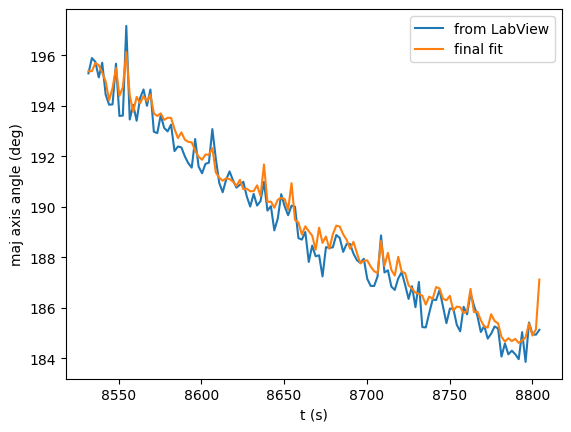

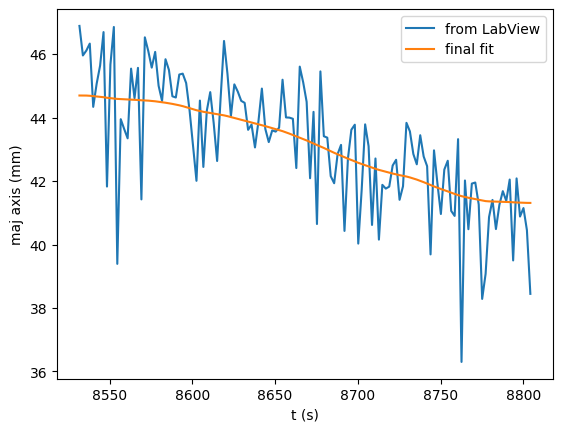

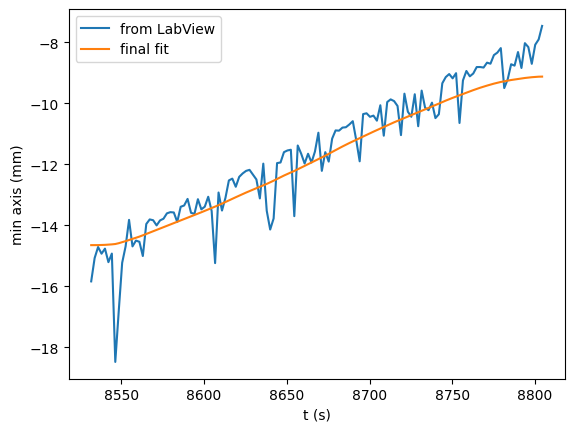

1/3 experiments fit
loading and fitting: /content/data/20230407132509/20230407132509_orbit.txt
/content/data/20230407132509/20230407132509_orbit.txt: orbitFilePath - recorded interval = 74593.9 to 74912.2 - trimmed to 74593.9 to 74910.1
1/4: calculating initial guess for magnet parameters
elapsed time: 33.1s
2/4: calculating orbits spaced over experiment duration
elapsed time: 53.0s
3/4: fitting every orbit together
elapsed time: 170.0s
4/4: fitting every orbit together, with higher temporal resolution
done! elapsed time: 257.6s


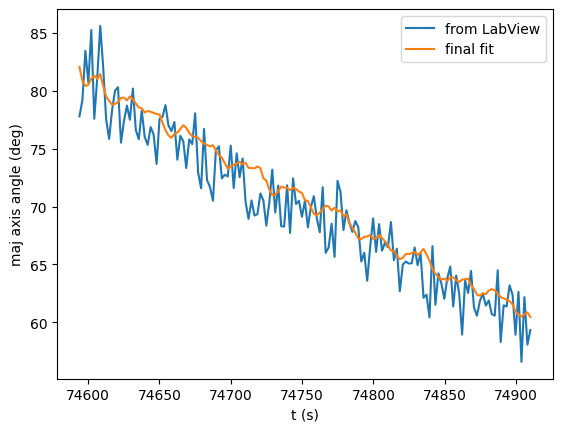

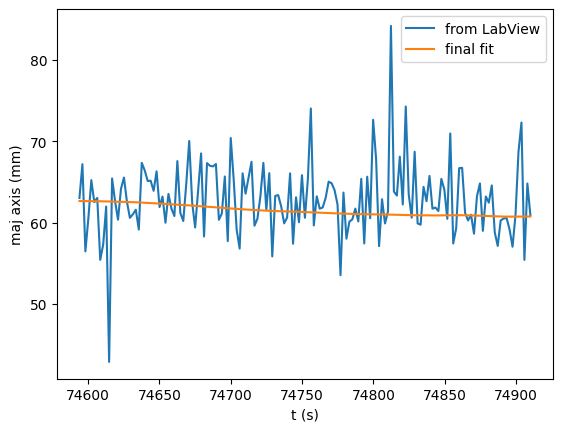

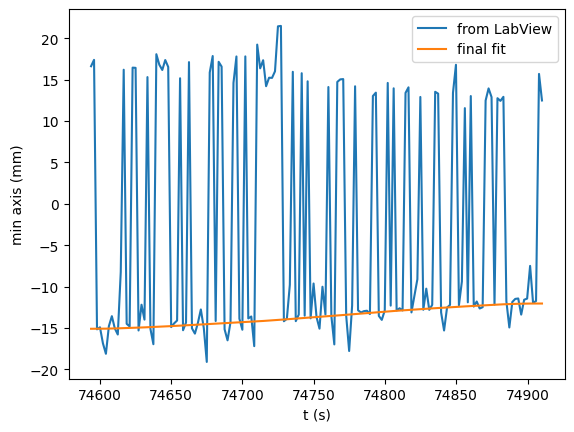

2/3 experiments fit
loading and fitting: /content/data/20230407133347/20230407133347_orbit.txt
/content/data/20230407133347/20230407133347_orbit.txt: orbitFilePath - recorded interval = 75111.0 to 75410.5 - trimmed to 75111.0 to 75408.4
1/4: calculating initial guess for magnet parameters
elapsed time: 2.1s
2/4: calculating orbits spaced over experiment duration
elapsed time: 13.9s
3/4: fitting every orbit together
elapsed time: 64.8s
4/4: fitting every orbit together, with higher temporal resolution
done! elapsed time: 280.2s


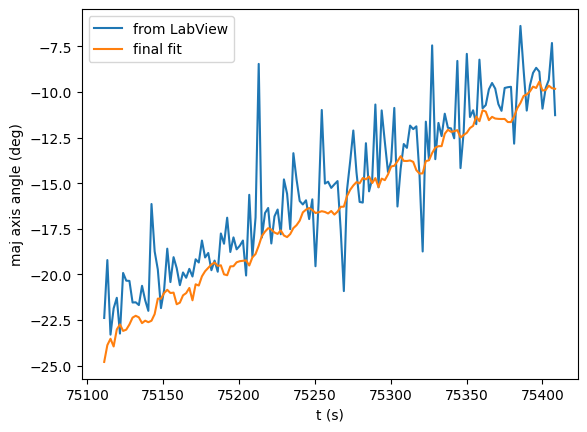

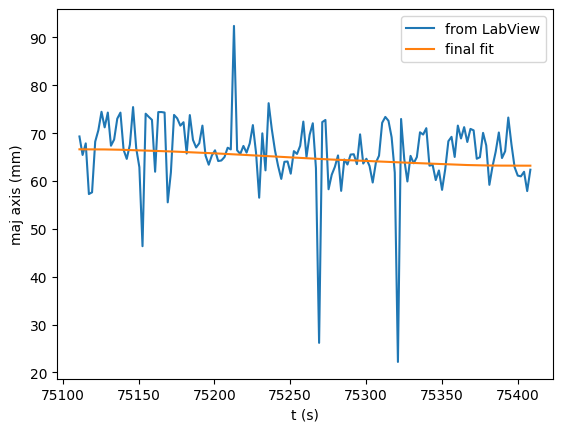

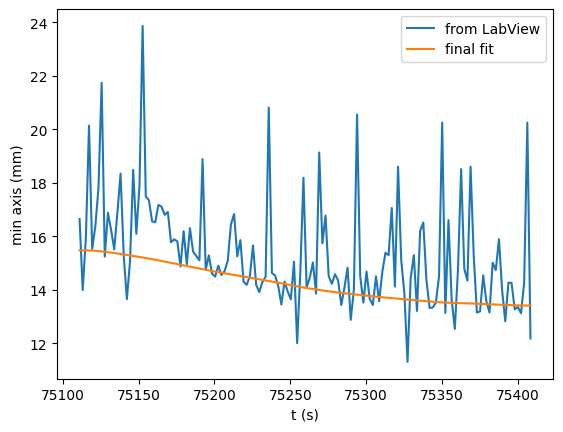

3/3 experiments fit
20230404122238_orbit.txt: offset = 0.3mm, -0.6mm 	 h = 49.7 mm 	 tilt = 5.2 deg 	 MAG0 = 93 arb units	
measured rotation = -8.260501821012168 deg; predicted anharmonic rotation = -7.931776992980783
20230407132509_orbit.txt: offset = -1.4mm, 2.2mm 	 h = 48.9 mm 	 tilt = 5.7 deg 	 MAG0 = 89 arb units	
measured rotation = -21.603214549637066 deg; predicted anharmonic rotation = -15.007950822522941
20230407133347_orbit.txt: offset = -1.3mm, 2.7mm 	 h = 48.9 mm 	 tilt = 4.7 deg 	 MAG0 = 90 arb units	
measured rotation = 14.968632723775752 deg; predicted anharmonic rotation = 15.585290511529493


In [3]:
!git -C /content/data pull
updateExperiments(startdir, experiments)

for e in experiments:
  a = e.fitResults.majaxis
  b = e.fitResults.minaxis
  L = e.L
  w = 2*np.pi/e.period
  t = e.fitResults.t
  theta = e.fitResults.theta
  print('{}: offset = {:.1f}mm, {:.1f}mm \t h = {:.1f} mm \t tilt = {:.1f} deg \t MAG0 = {:.0f} arb units\t'.format(os.path.basename(e.orbitPath), e.fitResults.offset[0], e.fitResults.offset[1], e.fitResults.height, np.rad2deg(e.fitResults.tilt), e.fitResults.mag0))
  print('measured rotation = {} deg; predicted anharmonic rotation = {}'.format(np.rad2deg(theta[-1] - theta[0]), np.rad2deg(np.sum(.375*a*b/L**2*w*np.gradient(t)))))

In [4]:
experiments[0].fitResults.height

49.68303311909223

## Run this block to save your data to a json file
This stores the experimental parameters you entered and the fitting results (but NOT the raw magnetometer data) to a single text file in json format. 

**you should copy this file to your individual github repository AND to the shared class repository**

1. open the file explorer to the left, click on the dots next to the file name and download to the local computer
2. copy the file into the local github repository location, then use github desktop to sync OR use the web interface to upload directly
3. use the web interface to upload the same file to the class repository - don't forget to enter a commit message and save. Note that your commit messages will be publicly visible to the world, so don't include your name or any naughty words.



In [5]:
fits = []
for e in experiments:
  fits.append({"orbitPath":e.orbitPath, "magPath":e.magPath, "pulsePath":e.pulsePath, "period":e.period, "L":e.L, "MAG0":e.fitResults.mag0, "t":e.fitResults.t.tolist(), "majaxis":e.fitResults.majaxis.tolist(), "minaxis":e.fitResults.minaxis.tolist(), "theta":e.fitResults.theta.tolist(),
               "phaseOffset":e.fitResults.po[DPHI,:].tolist(), "fixedParams":e.fitResults.pf.tolist(), "orbitParams":e.fitResults.po.tolist(), 
               "t_labview":e.orbit.tcross.tolist(), "majaxis_labview":e.orbit.majaxis.tolist(), "minaxis_labview":e.orbit.minaxis.tolist(), "theta_labview":e.orbit.theta.tolist(),            
               "pulseEnergy":e.pulse.U.tolist(), "pulseTime":e.pulse.t.tolist(), "pulseCounter":e.pulse.nc.tolist(), "pulseVoltage":e.pulse.V.tolist(), "pulseCharge":e.pulse.C.tolist()})
results = {"setupNumber":setupNumber, "section":section, "thetaWall":np.deg2rad(angleOfWall), "mass":mass, "energyCalibrationFactor":energyCalibrationFactor, "fits":fits}
outputname = 'section{:d}setup{:d}-{}.json'.format(int(section), int(setupNumber), date)
file = open(outputname, 'w')
json.dump(results, file)
file.close()

print('data saved in {} - BE SURE TO COPY TO YOUR GITHUB'.format(outputname))

data saved in section1setup7-05-Apr-2023.json - BE SURE TO COPY TO YOUR GITHUB
